In [2]:

import importlib.util
import matplotlib.animation as animation
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math
from functools import partial

from pydantic import validate_call

import gdsfactory as gf

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [4]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
ict_api = lumapi.INTERCONNECT(hide = False)

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [5]:
ict_api.expressioncheckoff()

In [6]:
um = 1e-6
nm = 1e-9

In [11]:
ng_ideal = 4.3458796
ng_pdk = 4.19088
neff = 2.3531702


neff_pdk = 2.44553
L = 20.3 * um
lambda_0 = 1546.363 * nm

power_couplings1 = [0.5, 0.13, 0.12, 0.5]

def delay_length(cascate,horizontal_section,mzi,fsr_ofc,ng,neff):
    
    
    dl_base = (lambda_0**2 / (2*fsr_ofc * nm * ng))*(2**(cascate-3))
    dl_shift = (lambda_0 / neff)
    
    match horizontal_section*(cascate**2):
        case 0: shift = 0
        case 1: shift = 0.25
        case 2: shift = 0.125
        case 3: shift = 0.375
        case 4: shift = 0.75

    Delay_Length=dl_base+(dl_shift*shift)
    
    match mzi:
        case 0: dl = Delay_Length
        case 1: dl = 2*Delay_Length
        case 2: dl = 2*Delay_Length+(dl_shift/2)
    
    return(dl)


# Ideal MZI simulation

## Making the circuit

In [12]:
def lattice_filter(fsr,ORDEM1,ORDEM21,ORDEM22,ORDEM31,ORDEM32,ORDEM33,ORDEM34):

    X = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
    Y = {0: 0, 1: -1, 2: 1, 3: -2, 4: -1, 5: 1, 6: 2}
    
    Coupler="ebeam_dc_te1550"
    Straight_Waveguide='ebeam_wg_integral_1550'
    ng=4.19088
    neff=2.44553
    TE_gain="'TE' gain (dB)"
    lenght_name='wg_length'
    port='opt_'

    ict_api.switchtodesign()

    ict_api.deleteall()


    ict_api.addelement("Optical Network Analyzer")
    ict_api.set("name","ONA")
    ict_api.set("number of points",10000)
    ict_api.set("input parameter",2)
    ict_api.set("start frequency",c/(1500*nm))
    ict_api.set("stop frequency",c/(1600*nm))
    ict_api.setposition("ONA",0,0)
    ict_api.set("number of input ports", 8)

    for n in range (4):           
        x= X[n+3]
        y= Y[n+3]
        if n==0: ordem=ORDEM31
        if n==1: ordem=ORDEM32
        if n==2: ordem=ORDEM33
        if n==3: ordem=ORDEM34
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitterC{n}{i}")
            ict_api.set("coupling_length",coupling_length[i])
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvgC{n}{i}")
            ict_api.set(lenght_name,L+delay_length(1,n,i,fsr,ng,neff))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2C{n}{i}")
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/4)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100 
            ict_api.setposition(f"splitterC{n}{i}",xs,ys)
            ict_api.setposition(f"wvgC{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2C{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitterC{n}{i}", f"{port}3", f"wvgC{n}{i}", "port 1")
            ict_api.connect(f"splitterC{n}{i}", f"{port}4", f"wvg2C{n}{i}", "port 1")
            if i>0:
                ict_api.connect(f"wvgC{n}{i-1}", "port 2", f"splitterC{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2C{n}{i-1}", "port 2", f"splitterC{n}{i}", f"{port}2")
                ict_api.select(f"wvgC{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2C{n}{i}")
                ict_api.set(lenght_name,L+delay_length(1,n,i,fsr,ng,neff))
            if i==(ordem-1):
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combinerC{n}{i}")
                ict_api.setposition(f"combinerC{n}{i}",xc,yc)   
                ict_api.set("coupling_length",coupling_length[i+1])
                ict_api.connect(f"wvgC{n}{i}", "port 2", f"combinerC{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2C{n}{i}", "port 2", f"combinerC{n}{i}", f"{port}2")
                ict_api.connect(f"combinerC{n}{i}", f"{port}3","ONA", f"input {2*n+1}")
                ict_api.connect(f"combinerC{n}{i}", f"{port}4","ONA", f"input {2*n+2}")
                

                        
    for n in range (2):
        
        x= X[n+1]
        y= Y[n+1]
        if n==0: ordem=ORDEM21
        if n==1: ordem=ORDEM22
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitterB{n}{i}")   
            ict_api.set("coupling_length",coupling_length[i])
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvgB{n}{i}")    
            ict_api.set(lenght_name,L+ delay_length(2,n,i,fsr,ng,neff))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2B{n}{i}")
            ict_api.set(lenght_name,L )
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/3)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100
            
            ict_api.setposition(f"splitterB{n}{i}",xs,ys)
            ict_api.setposition(f"wvgB{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2B{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitterB{n}{i}", f"{port}3", f"wvgB{n}{i}", "port 1")
            ict_api.connect(f"splitterB{n}{i}", f"{port}4", f"wvg2B{n}{i}", "port 1")
            if i>0:
                ict_api.connect(f"wvgB{n}{i-1}", "port 2", f"splitterB{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2B{n}{i-1}", "port 2", f"splitterB{n}{i}", f"{port}2")
                ict_api.select(f"wvgB{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2B{n}{i}")
                ict_api.set(lenght_name,L+delay_length(2,n,i,fsr,ng,neff))
                

            if i==(ordem-1):
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combinerB{n}{i}")
                ict_api.setposition(f"combinerB{n}{i}",xc,yc)   
                ict_api.set("coupling_length",coupling_length[i+1])
                ict_api.connect(f"wvgB{n}{i}", "port 2", f"combinerB{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2B{n}{i}", "port 2", f"combinerB{n}{i}", f"{port}2")
                ict_api.connect(f"combinerB{n}{i}", f"{port}3",f"splitterC{2*n}0",f"{port}2")
                ict_api.connect(f"combinerB{n}{i}", f"{port}4",f"splitterC{2*n+1}0", f"{port}1")
                
                

    
    for i in range (ORDEM1):
            
        if ORDEM1==1: coupling_length = [17.5*um,17.5*um]
        if ORDEM1==2: coupling_length = [17.5*um,10*um,5*um]
        if ORDEM1==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
        
        ict_api.addelement(Coupler)
        ict_api.set("name",f"splitterA{i}")   
        ict_api.set("coupling_length",coupling_length[i])
        ict_api.addelement(Straight_Waveguide)
        ict_api.set("name",f"wvgA{i}")
        ict_api.set(lenght_name,L+delay_length(3,0,i,fsr,ng,neff))
        ict_api.addelement(Straight_Waveguide)
        ict_api.set("name",f"wvg2A{i}")
        ict_api.set(lenght_name,L)
        
        xs = -1000 + (i*400)
        ys = +1500 
        xc=xs+400
        yc=ys
        xw1=xs+200
        yw1=ys-100
        xw2=xw1
        yw2= ys+100
        
        ict_api.setposition(f"splitterA{i}",xs,ys)
        ict_api.setposition(f"wvgA{i}",xw1,yw1)
        ict_api.setposition(f"wvg2A{i}",xw2,yw2)
        
        ict_api.connect(f"splitterA{i}", f"{port}3", f"wvgA{i}", "port 1")
        ict_api.connect(f"splitterA{i}", f"{port}4", f"wvg2A{i}", "port 1")
        
        if i>0:
            ict_api.connect(f"wvgA{i-1}", "port 2", f"splitterA{i}", f"{port}1")
            ict_api.connect(f"wvg2A{i-1}", "port 2", f"splitterA{i}", f"{port}2")
            ict_api.select(f"wvgA{i}")
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            ict_api.select(f"wvg2A{i}")
            ict_api.set(lenght_name,L+delay_length(3,0,i,fsr,ng,neff))

        if i==(ORDEM1-1):
            ict_api.addelement(Coupler)
            ict_api.set("name",f"combinerA{i}")
            ict_api.setposition(f"combinerA{i}",xc,yc)   
            ict_api.set("coupling_length",coupling_length[i+1])
            ict_api.connect(f"wvgA{i}", "port 2", f"combinerA{i}", f"{port}1")
            ict_api.connect(f"wvg2A{i}", "port 2", f"combinerA{i}", f"{port}2")
            ict_api.connect(f"combinerA{i}", f"{port}3",f"splitterB00", f"{port}2")
            ict_api.connect(f"combinerA{i}", f"{port}4",f"splitterB10", f"{port}1")
            
        
    ict_api.connect("splitterA0", f"{port}2","ONA", "output")
    
    ict_api.switchtodesign()
    ict_api.run()
        
    plt.figure(figsize=(10,6))  # Tamanho do gráfico

    for input in range(8):
        wavelength = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")['wavelength']
        te_gain_db = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")[TE_gain]
        plt.plot(wavelength*1e9, te_gain_db, label=f'Input {input+1}')  # X em nm

    # Configurações atualizadas
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(TE_gain)
    plt.title(f'Lattice Filter - All Inputs a-{ORDEM1} b-{ORDEM21} c-{ORDEM22} d-{ORDEM31} e-{ORDEM32} f-{ORDEM33} g-{ORDEM34}')
    plt.grid(True)
    plt.legend()
    plt.xlim(1545,1555)#1530, 1565)  # Novo limite X
    plt.ylim(-15,0)    # Novo limite Y
    plt.hlines(-3, 1530, 1565,linestyles="--",)
    ##plt.savefig(f"C:\\Users\\juame\\Downloads\\lattice filter\\Optimização ordem\\ a-{ORDEM1}_b-{ORDEM21}_c-{ORDEM22}_d-{ORDEM31}_e-{ORDEM32}_f-{ORDEM33}_g-{ORDEM34}.png")
    plt.show()

a perda diminui um pouco ao diminuir o acoplador do meio de 12.5 pra 10 um, os outros acopladores ja estão otimizados


        2
      /  
    2
   /  \
  /     1
2
  \     1
   \  /
    1
      \
        1

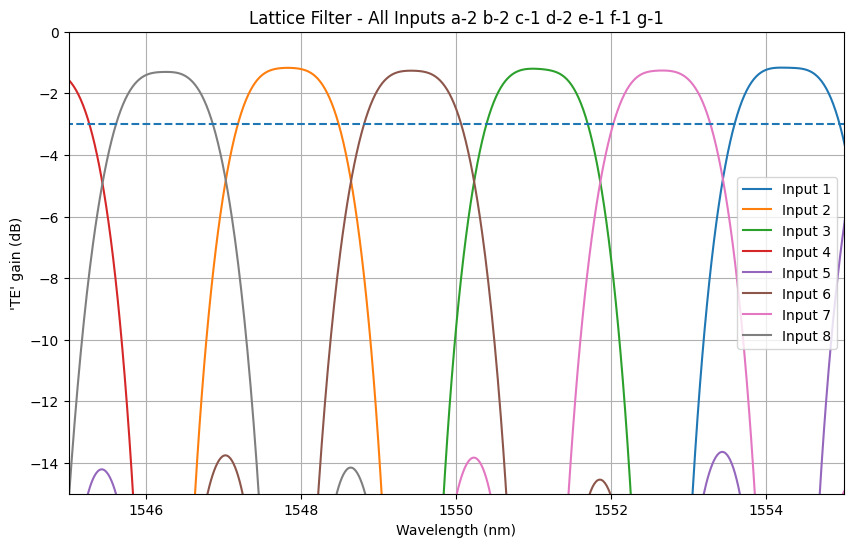

In [13]:
lattice_filter(1.6,2,2,1,2,1,1,1)

Alterar monte carlo em 0.12

In [123]:
def montecarlo(ORDEM1,ORDEM21,ORDEM22,ORDEM31,ORDEM32,ORDEM33,ORDEM34):

    sweep_name = "Monte Carlo analysis"
    nop=10
    ict_api.deletesweep(sweep_name)
    ict_api.addsweep(2)
    ict_api.setsweep('sweep','name',sweep_name)
    ict_api.setsweep(sweep_name, "type", "Ranges")
    ict_api.setsweep(sweep_name, "number of points", nop)

    for n in range (1):           
        if n==0: ordem=ORDEM31
        if n==1: ordem=ORDEM32
        if n==2: ordem=ORDEM33
        if n==3: ordem=ORDEM34
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            para = {}
            para['Name']= f"splitterC{n}{i}"
            para['Parameter']= f"::Root Element::splitterC{n}{i}::coupling_length"
            para['Min']= (coupling_length[i]-4*um)
            para['Max']= (coupling_length[i]+4*um)
            ict_api.addsweepparameter(sweep_name,para) 
            
            if i==(ordem-1):
                para = {}
                para['Name']= f"combinerC{n}{i}"
                para['Parameter']= f"::Root Element::combinerC{n}{i}::coupling_length"
                para['Min']= (coupling_length[i+1]-4*um)
                para['Max']= (coupling_length[i+1]+4*um)
                ict_api.addsweepparameter(sweep_name,para) 
                
'''
                        
    for n in range (2):

        if n==0: ordem=ORDEM21
        if n==1: ordem=ORDEM22
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            para = {}
            para['Name']= f"splitterB{n}{i}"
            para['Parameter']= f"::Root Element::splitterB{n}{i}::coupling_length"
            para['Min']= (coupling_length[i]-4)
            para['Max']= (coupling_length[i]+4)
            ict_api.addsweepparameter(sweep_name,para)          

            if i==(ordem-1):
                para = {}
                para['Name']= f"combinerB{n}{i}"
                para['Parameter']= f"::Root Element::combinerB{n}{i}::coupling_length"
                para['Min']= (coupling_length[i+1]-4)
                para['Max']= (coupling_length[i+1]+4)
                ict_api.addsweepparameter(sweep_name,para)    
                

                
                

    
    for i in range (ORDEM1):
            
        if ORDEM1==1: coupling_length = [17.5*um,17.5*um]
        if ORDEM1==2: coupling_length = [17.5*um,10*um,5*um]
        if ORDEM1==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
        para = {}
        para['Name']= f"splitterA{i}"
        para['Parameter']= f"::Root Element::splitterA{i}::coupling_length"
        para['Min']= (coupling_length[i]-4)
        para['Max']= (coupling_length[i]+4)
        ict_api.addsweepparameter(sweep_name,para)
        if i==(ORDEM1-1):
            para = {}
            para['Name']= f"combinerA{i}"
            para['Parameter']= f"::Root Element::combinerA{i}::coupling_length"
            para['Min']= (coupling_length[i+1]-4)
            para['Max']= (coupling_length[i+1]+4)
            ict_api.addsweepparameter(sweep_name,para)
            

    for i in range (8):
        resu = {}
        resu['Name']= f"input{i+1}"
        resu['Result']= f"::Root Element::ONA::input {i+1}/mode 1/gain"
        ict_api.addsweepresult(sweep_name,resu)    '''       


montecarlo(2,2,1,2,1,1,1)

LumApiError: 'Operation on closed application'

# Runnings and saving simulations

In [121]:
ict_api.save("teste da otimizacao")

In [122]:
ict_api.runsweep("Monte Carlo analysis")

In [ ]:
cl3 = np.linspace(4,6,5)
cl2 = np.linspace(9.5,12,5)
cl1 = np.linspace(2,22,5)
for i in range (5):
    lattice_filter(0.4,"ebeam_dc_te1550",'ebeam_wg_integral_1550',ng_pdk,neff_pdk,"'TE' gain (dB)",'wg_length','opt_')